In [89]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.gridspec as gridspec

df = pd.read_csv('Mage_combo_30_oct.csv', index_col=0)

CELL_LINES = ['k562', 'el4']

# lowercase the columns for ease of processing
df.columns = [col.lower() for col in df.columns]

df

,sequence,model,sampling_method,wt_for_design,tcrdock_pae,hamming_distances_from_magea3,hamming_distance_from_titin,af3_ranking_scores,mw,weight,ul exact,c exact if 477,r1_k562,r2_k562,r3_k562,r1_el4,r2_el4,r3_el4,is_binder_by_netmhcpan,is_binder_by_netmhcpan__weak
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
mage_p2_titin,ESDPIVAQY,titin_wt,NaN,titin,5.025015,4.0,0.0,0.983471,1021.09,0.5,489.672801,1.026568,41.555686,42.433795,43.405351,3.573628,4.372790,4.392098,1.0,1.0
mage_p3,EVDPVGLLF,so3_convnet_noise=0p5__fixed_E1,fixed_structure,magea3,5.198635,3.0,6.0,1.036476,988.15,0.5,505.996053,1.060788,28.398262,22.043226,25.519417,0.878866,1.132701,0.855888,1.0,1.0
mage_p4,YLDPLQPEY,so3_convnet_noise=0p5,sim_anneal,magea3,5.196480,6.0,6.0,1.078432,1137.26,0.5,439.653202,0.921705,27.727075,29.433227,25.115109,0.507988,1.117083,0.618809,1.0,1.0
mage_p5,ELDLIPLTY,so3_convnet_noise=0p5__fixed_E1,sim_anneal,magea3,5.194169,5.0,5.0,1.167458,1076.26,0.5,464.571758,0.973945,16.821289,16.721479,15.666947,0.455669,0.442166,0.675615,1.0,1.0
mage_p6,MTDPIGQDF,so3_convnet_base_ensemble,fixed_structure,magea3,5.193401,5.0,6.0,1.005794,1023.13,0.5,488.696451,1.024521,19.386561,17.332967,17.059366,0.546125,0.594933,0.864605,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mage_p93,YLDPIPLAY,so3_convnet_base_ensemble,sim_anneal,magea3,4.930145,5.0,5.0,1.059747,1064.25,0.5,469.814423,0.984936,20.386181,20.972637,19.706437,0.629081,0.858322,0.697556,1.0,1.0
mage_p94,YTDPIEDTF,so3_convnet_noise=0p5,fixed_structure,titin,4.929909,6.0,6.0,1.045234,1100.15,0.5,454.483479,0.952796,28.258978,35.428555,36.732154,0.597267,0.699770,0.711738,1.0,1.0
mage_p95,QSDPIESEY,so3_convnet_base_ensemble,fixed_structure,titin,4.922758,5.0,4.0,1.053901,1067.07,0.5,468.572821,0.982333,41.582055,49.523088,43.175452,7.090031,6.512232,5.031232,1.0,1.0


In [90]:
# compute and store cutoffs, control values, as well as response columns to be put on the dataframe

cell_line_to_cutoff = {}
# have to manually do it because pandas breaks downfor some reason if I then try to drop the unstim row, and try to use the unstim values
cell_line_to_control = {
    'k562': [18.621148, 23.846675, 21.820866],
    'el4': [0.475935, 0.534058, 0.334536]
}
cell_line_to_wt_scores = {}
cell_line_to_pae_scores = {}
cell_line_to_af3_pae_scores = {}
cell_line_to_ylim = {
    'k562': (0.5, 2),
    'el4': (-1, 1.5)
}
for cl in CELL_LINES:
    cell_line_to_cutoff[cl] = max(0.5, df.loc['unstim', [f'r1_{cl}', f'r2_{cl}', f'r3_{cl}']].mean() + df.loc['unstim', [f'r1_{cl}', f'r2_{cl}', f'r3_{cl}']].std() * 3)

    df[f'resp_{cl}'] = [True if elem > cell_line_to_cutoff[cl] else False for elem in df[[f'r1_{cl}', f'r2_{cl}', f'r3_{cl}']].mean(axis=1)]

    score_wt_1 = df.loc[df['model'] == 'magea3_wt', [f'r1_{cl}', f'r2_{cl}', f'r3_{cl}']].values[0]
    score_wt_2 = df.loc[df['model'] == 'titin_wt', [f'r1_{cl}', f'r2_{cl}', f'r3_{cl}']].values[0]
    cell_line_to_wt_scores[cl] = (score_wt_1, score_wt_2)

    cell_line_to_pae_scores[cl] = (df.loc[df['model'] == 'magea3_wt']['tcrdock_pae'].values[0], df.loc[df['model'] == 'titin_wt']['tcrdock_pae'].values[0])
    cell_line_to_af3_pae_scores[cl] = (df.loc[df['model'] == 'magea3_wt']['af3_ranking_scores'].values[0], df.loc[df['model'] == 'titin_wt']['af3_ranking_scores'].values[0])
    # I think af3_ranking_scores here is actually the pae score? based solely on the values

# df['resp'] = df['resp_k562'] | df['resp_el4']

for cl in CELL_LINES:
    df[f'r_{cl}_mean'] = [np.mean([r1, r2, r3]) for r1, r2, r3 in zip(df[f'r1_{cl}'], df[f'r2_{cl}'], df[f'r3_{cl}'])]

df.drop(['unstim', 'mage_p1_wt', 'mage_p2_titin'], inplace=True)

df


,sequence,model,sampling_method,wt_for_design,tcrdock_pae,hamming_distances_from_magea3,hamming_distance_from_titin,af3_ranking_scores,mw,weight,...,r3_k562,r1_el4,r2_el4,r3_el4,is_binder_by_netmhcpan,is_binder_by_netmhcpan__weak,resp_k562,resp_el4,r_k562_mean,r_el4_mean
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
mage_p3,EVDPVGLLF,so3_convnet_noise=0p5__fixed_E1,fixed_structure,magea3,5.198635,3.0,6.0,1.036476,988.15,0.5,...,25.519417,0.878866,1.132701,0.855888,1.0,1.0,False,True,25.320302,0.955819
mage_p4,YLDPLQPEY,so3_convnet_noise=0p5,sim_anneal,magea3,5.196480,6.0,6.0,1.078432,1137.26,0.5,...,25.115109,0.507988,1.117083,0.618809,1.0,1.0,False,False,27.425137,0.747960
mage_p5,ELDLIPLTY,so3_convnet_noise=0p5__fixed_E1,sim_anneal,magea3,5.194169,5.0,5.0,1.167458,1076.26,0.5,...,15.666947,0.455669,0.442166,0.675615,1.0,1.0,False,False,16.403238,0.524483
mage_p6,MTDPIGQDF,so3_convnet_base_ensemble,fixed_structure,magea3,5.193401,5.0,6.0,1.005794,1023.13,0.5,...,17.059366,0.546125,0.594933,0.864605,1.0,1.0,False,False,17.926298,0.668554
mage_p7,HQDPIGLKY,so3_convnet_noise=0p5,fixed_structure,magea3,5.193282,4.0,5.0,1.057895,1070.22,0.5,...,16.674007,0.566111,0.478189,0.423317,1.0,1.0,False,False,18.479052,0.489205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mage_p91,ELDPIPLGF,so3_convnet_noise=0p5__fixed_E1,sim_anneal,magea3,4.931764,5.0,5.0,1.008377,1000.16,0.5,...,27.814319,1.440270,3.068014,0.957654,1.0,1.0,False,True,27.904655,1.821979
mage_p92,ESDPIEDEY,so3_convnet_base_ensemble,fixed_structure,titin,4.930344,4.0,3.0,1.050419,1096.07,0.5,...,43.239838,8.132715,10.077263,8.931099,1.0,1.0,True,True,45.481563,9.047026
mage_p93,YLDPIPLAY,so3_convnet_base_ensemble,sim_anneal,magea3,4.930145,5.0,5.0,1.059747,1064.25,0.5,...,19.706437,0.629081,0.858322,0.697556,1.0,1.0,False,False,20.355085,0.728320


In [91]:


resp_to_color = {True: 'darkorange', False: 'mediumaquamarine'}
model_to_marker = {'magea3_wt': 'X', 'titin_wt': 'X',
                   'so3_convnet_base_ensemble__fixed_structure': 's',
                   'so3_convnet_noise=0p5__fixed_structure': 'd',
                   'so3_convnet_base_ensemble__sim_anneal': '<',
                   'so3_convnet_noise=0p5__sim_anneal': '>',
                   'so3_convnet_base_ensemble__fixed_E1__sim_anneal': '^',
                   'so3_convnet_base_ensemble__fixed_E1__fixed_structure': 'v',
                   'so3_convnet_noise=0p5__fixed_E1__sim_anneal': 'o',
                   'so3_convnet_noise=0p5__fixed_E1__fixed_structure': 'O',}

models = list(model_to_marker.keys())

def get_model_mask(df, model_and_method):
    if len(model_and_method.split('__')) == 1:
        return df['model'] == model_and_method
    elif len(model_and_method.split('__')) == 2:
        return (df['model'] == model_and_method.split('__')[0]) & (df['sampling_method'] == model_and_method.split('__')[1])
    elif len(model_and_method.split('__')) == 3:
        return (df['model'] == '__'.join([model_and_method.split('__')[0], model_and_method.split('__')[1]])) & (df['sampling_method'] == model_and_method.split('__')[2])
    else:
        raise ValueError('model_and_method must have at most one "__"')

df['min_hamming_distance_from_struc'] = np.min(df[['hamming_distances_from_magea3', 'hamming_distance_from_titin']], axis=1)

hamming_distance_from_resp_struc = []
for i, row in df.iterrows():
    if row["wt_for_design"] == 'magea3':
        hamming_distance_from_resp_struc.append(row['hamming_distances_from_magea3'])
    elif row["wt_for_design"] == 'titin':
        hamming_distance_from_resp_struc.append(row['hamming_distance_from_titin'])
df['hamming_distance_from_resp_struc'] = hamming_distance_from_resp_struc

df

,sequence,model,sampling_method,wt_for_design,tcrdock_pae,hamming_distances_from_magea3,hamming_distance_from_titin,af3_ranking_scores,mw,weight,...,r2_el4,r3_el4,is_binder_by_netmhcpan,is_binder_by_netmhcpan__weak,resp_k562,resp_el4,r_k562_mean,r_el4_mean,min_hamming_distance_from_struc,hamming_distance_from_resp_struc
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
mage_p3,EVDPVGLLF,so3_convnet_noise=0p5__fixed_E1,fixed_structure,magea3,5.198635,3.0,6.0,1.036476,988.15,0.5,...,1.132701,0.855888,1.0,1.0,False,True,25.320302,0.955819,3.0,3.0
mage_p4,YLDPLQPEY,so3_convnet_noise=0p5,sim_anneal,magea3,5.196480,6.0,6.0,1.078432,1137.26,0.5,...,1.117083,0.618809,1.0,1.0,False,False,27.425137,0.747960,6.0,6.0
mage_p5,ELDLIPLTY,so3_convnet_noise=0p5__fixed_E1,sim_anneal,magea3,5.194169,5.0,5.0,1.167458,1076.26,0.5,...,0.442166,0.675615,1.0,1.0,False,False,16.403238,0.524483,5.0,5.0
mage_p6,MTDPIGQDF,so3_convnet_base_ensemble,fixed_structure,magea3,5.193401,5.0,6.0,1.005794,1023.13,0.5,...,0.594933,0.864605,1.0,1.0,False,False,17.926298,0.668554,5.0,5.0
mage_p7,HQDPIGLKY,so3_convnet_noise=0p5,fixed_structure,magea3,5.193282,4.0,5.0,1.057895,1070.22,0.5,...,0.478189,0.423317,1.0,1.0,False,False,18.479052,0.489205,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mage_p91,ELDPIPLGF,so3_convnet_noise=0p5__fixed_E1,sim_anneal,magea3,4.931764,5.0,5.0,1.008377,1000.16,0.5,...,3.068014,0.957654,1.0,1.0,False,True,27.904655,1.821979,5.0,5.0
mage_p92,ESDPIEDEY,so3_convnet_base_ensemble,fixed_structure,titin,4.930344,4.0,3.0,1.050419,1096.07,0.5,...,10.077263,8.931099,1.0,1.0,True,True,45.481563,9.047026,3.0,3.0
mage_p93,YLDPIPLAY,so3_convnet_base_ensemble,sim_anneal,magea3,4.930145,5.0,5.0,1.059747,1064.25,0.5,...,0.858322,0.697556,1.0,1.0,False,False,20.355085,0.728320,5.0,5.0


In [98]:
print(np.max(df['af3_ranking_scores']))

1.224988112


In [4]:
# def make_barplot_single_cell_line(df, cl):

#     import matplotlib
#     matplotlib.rcParams['pdf.fonttype'] = 42
#     matplotlib.rcParams['ps.fonttype'] = 42

#     fontsize = 18

#     # make a barplot of success over distance from wildtype for the 4 model classes
#     model_groups = [('so3_convnet_base_ensemble__fixed_structure', 'so3_convnet_noise=0p5__fixed_structure', 'so3_convnet_base_ensemble__fixed_E1__fixed_structure', 'so3_convnet_noise=0p5__fixed_E1__fixed_structure'),
#                     ('so3_convnet_base_ensemble__sim_anneal', 'so3_convnet_noise=0p5__sim_anneal', 'so3_convnet_base_ensemble__fixed_E1__sim_anneal', 'so3_convnet_noise=0p5__fixed_E1__sim_anneal')]
#     model_group_names = ['fixed', 'annealing']
#     colors = ['tab:red', 'tab:pink']

#     plt.figure(figsize=(13, 5))
#     ax = plt.gca()

#     df_here = df.copy()

#     all_distances = sorted(np.unique(df_here['min_hamming_distance_from_struc'].values))

#     for i, (model_group, model_group_name, color) in enumerate(zip(model_groups, model_group_names, colors)):
#         masks = [get_model_mask(df_here, model) for model in model_group]
#         mask = np.logical_or.reduce(masks)
#         curr_df = df_here[mask]
#         distances = curr_df['min_hamming_distance_from_struc'].values
#         responses = curr_df[f'resp_{cl}'].values

#         distance_to_resp = {}
#         distance_to_exp_score = {}
#         distance_to_mean_exp_score = {}
#         distance_to_is_e1 = {}
#         for distance in np.unique(distances):
#             dist_mask = distances == distance
#             distance_to_resp[distance] = {True: np.sum(responses[dist_mask]), False: np.sum(~responses[dist_mask])}
#             distance_to_exp_score[distance] = np.vstack([curr_df[dist_mask][f'r1_{cl}'],
#                                                             curr_df[dist_mask][f'r2_{cl}'],
#                                                             curr_df[dist_mask][f'r3_{cl}']])
#             distance_to_mean_exp_score[distance] = np.mean(distance_to_exp_score[distance], axis=0)
#             distance_to_is_e1[distance] = curr_df[dist_mask]['model'].str.contains('fixed_E1').values
        
#         distances = list(distance_to_exp_score.keys())
#         scores = [np.log10(distance_to_exp_score[distance]) for distance in distances]
#         mean_scores = [np.log10(distance_to_mean_exp_score[distance]) for distance in distances]
#         is_e1_list = [distance_to_is_e1[distance] for distance in distances]

#         positions = [distance - 0.2 + i*0.4 for distance in distances]

#         ax.boxplot(mean_scores, positions=positions, showfliers=False, widths=0.35, patch_artist=True, boxprops=dict(facecolor=color, alpha=0.5), medianprops=dict(color="black", linewidth=1))

#         k = 0
#         for position, scores_in_distance, is_e1 in zip(positions, mean_scores, is_e1_list):
#             if len(scores_in_distance.shape) == 2:
#                 scores_in_distance = scores_in_distance.T

#             for val in [True, False]:

#                 if val:
#                     is_e1_mask = is_e1
#                     marker = 'o'
#                 else:
#                     is_e1_mask = ~is_e1
#                     marker = 'x'

#                 for item in scores_in_distance[is_e1_mask]:
#                     noise = np.random.uniform(-0.15, 0.15)
#                     len_item = len(item) if isinstance(item, np.ndarray) else 1
#                     if k == 0:
#                         ax.scatter([position+noise]*len_item, item, color=color, marker=marker, label=model_group_name)
#                         # ax.plot([position+noise]*len_item, item, color=color, linestyle='-', linewidth=0.5)
#                     else:
#                         ax.scatter([position+noise]*len_item, item, color=color, marker=marker)
#                         # ax.plot([position+noise]*len_item, item, color=color, linestyle='-', linewidth=0.5)
#                     k += 1

#         # put number of examples under each boxplot
#         ax.set_ylim(*cell_line_to_ylim[cl])
#         for position, distance, scores_in_distance in zip(positions, distances, mean_scores):
#             offset = 0.03 if i == 1 else -0.03
#             ax.text(position+offset, cell_line_to_ylim[cl][0]+0.05, f'{int(distance_to_resp[distance][True])}/{len(scores_in_distance)}', ha='center', va='bottom', fontsize=fontsize-4)


#     min_distance = min(all_distances)
#     wt_xtick = min_distance - 2.5
#     control_xtick = wt_xtick + 1

#     ax.scatter([wt_xtick-0.1]*len(cell_line_to_wt_scores[cl][0]), np.log10(cell_line_to_wt_scores[cl][0]), color='black', marker='s', s=50)
#     ax.scatter([wt_xtick+0.1]*len(cell_line_to_wt_scores[cl][1]), np.log10(cell_line_to_wt_scores[cl][1]), color='black', marker='d', s=50)
#     ax.scatter([control_xtick]*len(cell_line_to_control[cl]), np.log10(cell_line_to_control[cl]), color='black', marker='*', s=50)

#     ax.axhline(np.log10(cell_line_to_cutoff[cl]), color='black', linestyle=':', label='activity thresh.')

#     xticks = [wt_xtick, control_xtick] + list(all_distances)
#     xticklabels = ['WT', 'cntr'] + [str(int(distance)) for distance in all_distances]

#     ax.set_xticks(xticks)
#     ax.set_xticklabels(xticklabels)

#     # keep only major y tick labels that are integers
#     ticks_to_keep = [tick for tick in ax.get_yticks() if tick.is_integer()]
#     ax.set_yticks(ticks_to_keep)
    
#     ax.set_yticklabels(['$10^{}$'.format('{' + str(int(y)) + '}') for y in ax.get_yticks()])

#     ax.tick_params(axis='both', labelsize=fontsize)


#     ax.tick_params(axis='both', labelsize=fontsize)
#     ax.set_xlabel('distance from WT [aa]', fontsize=fontsize)
#     ax.set_ylabel('activity (GFP %)', fontsize=fontsize)

#     from matplotlib.lines import Line2D
#     from matplotlib.patches import Patch

#     # put legend outside of figure on the right

#     legend_handles = [Patch(facecolor='tab:red', alpha=0.8, label='fixed'),
#                       Patch(facecolor='tab:pink', alpha=0.8, label='annealing'),
#                       Line2D([0], [0], color='black', marker='o', linestyle='None', label='E1 constraint'),
#                       Line2D([0], [0], color='black', marker='x', linestyle='None', label='no constraints'),
#                       Line2D([0], [0], color='black', linestyle=':', label='activity thresh.'),
#                       Line2D([0], [0], color='black', marker='s', linestyle='None', label='WT MageA3'),
#                       Line2D([0], [0], color='black', marker='d', linestyle='None', label='WT Titin')]

#     ax.legend(handles=legend_handles, fontsize=fontsize-3, bbox_to_anchor=(1, 0.8))

#     plt.tight_layout()
#     # plt.savefig('__pretty_magea3_mean_exp_scores_vs_hamming_distance_from_wt.png')
#     # plt.savefig('__pretty_magea3_mean_exp_scores_vs_hamming_distance_from_wt.pdf')
#     plt.show()


# make_barplot_single_cell_line(df, 'k562')
# make_barplot_single_cell_line(df, 'el4')

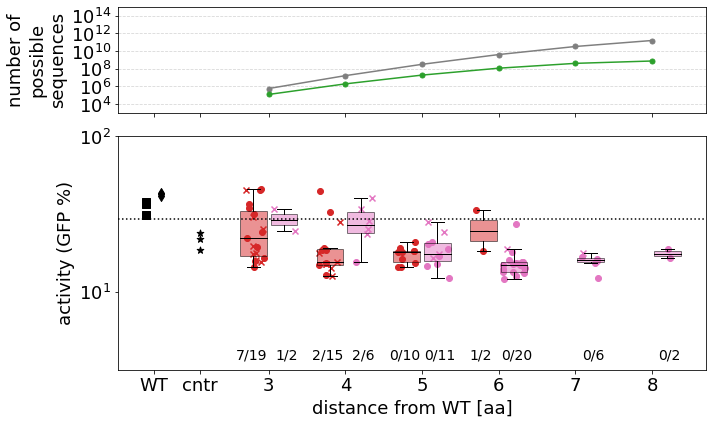

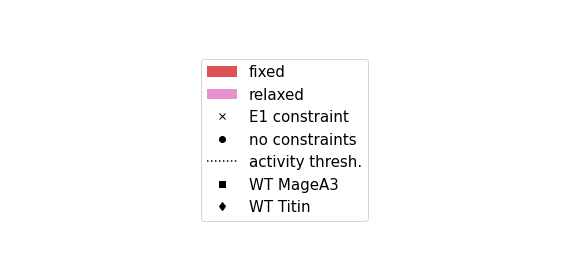

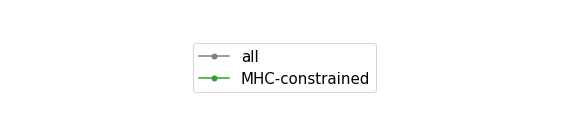

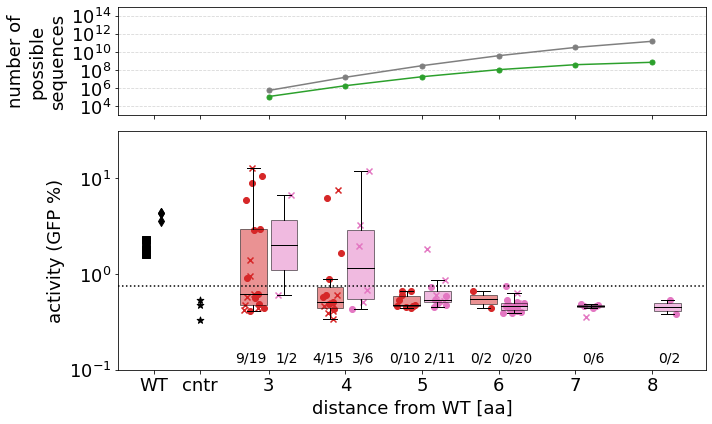

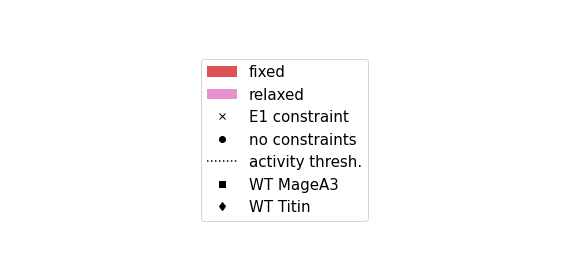

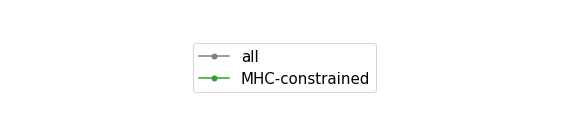

In [5]:
def make_barplot_single_cell_line(df, cl):

    fontsize = 18

    # make a barplot of success over distance from wildtype for the 4 model classes
    model_groups = [('so3_convnet_base_ensemble__fixed_structure', 'so3_convnet_noise=0p5__fixed_structure', 'so3_convnet_base_ensemble__fixed_E1__fixed_structure', 'so3_convnet_noise=0p5__fixed_E1__fixed_structure'),
                    ('so3_convnet_base_ensemble__sim_anneal', 'so3_convnet_noise=0p5__sim_anneal', 'so3_convnet_base_ensemble__fixed_E1__sim_anneal', 'so3_convnet_noise=0p5__fixed_E1__sim_anneal')]
    model_group_names = ['fixed', 'annealing']
    colors = ['tab:red', 'tab:pink']

    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2.2])

    # Bottom subplot
    ax = fig.add_subplot(gs[1])

    df_here = df.copy()

    all_distances = sorted(np.unique(df_here['min_hamming_distance_from_struc'].values))

    for i, (model_group, model_group_name, color) in enumerate(zip(model_groups, model_group_names, colors)):
        masks = [get_model_mask(df_here, model) for model in model_group]
        mask = np.logical_or.reduce(masks)
        curr_df = df_here[mask]
        distances = curr_df['min_hamming_distance_from_struc'].values
        responses = curr_df[f'resp_{cl}'].values

        distance_to_resp = {}
        distance_to_exp_score = {}
        distance_to_mean_exp_score = {}
        distance_to_is_e1 = {}
        for distance in np.unique(distances):
            dist_mask = distances == distance
            distance_to_resp[distance] = {True: np.sum(responses[dist_mask]), False: np.sum(~responses[dist_mask])}
            distance_to_exp_score[distance] = np.vstack([curr_df[dist_mask][f'r1_{cl}'],
                                                            curr_df[dist_mask][f'r2_{cl}'],
                                                            curr_df[dist_mask][f'r3_{cl}']])
            distance_to_mean_exp_score[distance] = np.mean(distance_to_exp_score[distance], axis=0)
            distance_to_is_e1[distance] = curr_df[dist_mask]['model'].str.contains('fixed_E1').values
        
        distances = list(distance_to_exp_score.keys())
        scores = [np.log10(distance_to_exp_score[distance]) for distance in distances]
        mean_scores = [np.log10(distance_to_mean_exp_score[distance]) for distance in distances]
        is_e1_list = [distance_to_is_e1[distance] for distance in distances]

        positions = [distance - 0.2 + i*0.4 for distance in distances]

        ax.boxplot(mean_scores, positions=positions, showfliers=False, widths=0.35, patch_artist=True, boxprops=dict(facecolor=color, alpha=0.5), medianprops=dict(color="black", linewidth=1))

        k = 0
        for position, scores_in_distance, is_e1 in zip(positions, mean_scores, is_e1_list):
            if len(scores_in_distance.shape) == 2:
                scores_in_distance = scores_in_distance.T

            for val in [True, False]:

                if val:
                    is_e1_mask = is_e1
                    marker = 'x'
                else:
                    is_e1_mask = ~is_e1
                    marker = 'o'

                for item in scores_in_distance[is_e1_mask]:
                    noise = np.random.uniform(-0.15, 0.15)
                    len_item = len(item) if isinstance(item, np.ndarray) else 1
                    if k == 0:
                        ax.scatter([position+noise]*len_item, item, color=color, marker=marker, label=model_group_name)
                        # ax.plot([position+noise]*len_item, item, color=color, linestyle='-', linewidth=0.5)
                    else:
                        ax.scatter([position+noise]*len_item, item, color=color, marker=marker)
                        # ax.plot([position+noise]*len_item, item, color=color, linestyle='-', linewidth=0.5)
                    k += 1

        # put number of examples under each boxplot
        ax.set_ylim(*cell_line_to_ylim[cl])
        for position, distance, scores_in_distance in zip(positions, distances, mean_scores):
            offset = 0.03 if i == 1 else -0.03
            ax.text(position+offset, cell_line_to_ylim[cl][0]+0.05, f'{int(distance_to_resp[distance][True])}/{len(scores_in_distance)}', ha='center', va='bottom', fontsize=fontsize-4)


    min_distance = min(all_distances)
    wt_xtick = min_distance - 1.5
    control_xtick = wt_xtick + 0.6

    ax.scatter([wt_xtick-0.1]*len(cell_line_to_wt_scores[cl][0]), np.log10(cell_line_to_wt_scores[cl][0]), color='black', marker='s', s=50)
    ax.scatter([wt_xtick+0.1]*len(cell_line_to_wt_scores[cl][1]), np.log10(cell_line_to_wt_scores[cl][1]), color='black', marker='d', s=50)
    ax.scatter([control_xtick]*len(cell_line_to_control[cl]), np.log10(cell_line_to_control[cl]), color='black', marker='*', s=50)

    ax.axhline(np.log10(cell_line_to_cutoff[cl]), color='black', linestyle=':', label='activity thresh.')

    xticks = [wt_xtick, control_xtick] + list(all_distances)
    xticklabels = ['WT', 'cntr'] + [str(int(distance)) for distance in all_distances]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    if cl == 'k562':
        yticks = [1, 2]
    elif cl == 'el4':
        yticks = [-1, 0, 1]
    
    ax.set_yticks(yticks, ['$10^{}$'.format('{' + str(int(y)) + '}') for y in yticks])

    ax.tick_params(axis='both', labelsize=fontsize)

    ax.tick_params(axis='both', labelsize=fontsize)
    ax.set_xlabel('distance from WT [aa]', fontsize=fontsize)
    ax.set_ylabel('activity (GFP %)', fontsize=fontsize)


    import json
    with open('all_possibilities_class_I_A0101_9_mage_k_to_num_sequences.json', 'r') as f:
        k_to_num_sequences_all = json.load(f)
    with open('mhc_constrainted_class_I_A0101_9_mage_k_to_num_sequences.json', 'r') as f:
        k_to_num_sequences_mhc = json.load(f)

    all_values = [k_to_num_sequences_all[str(int(k))] for k in all_distances]
    mhc_values = [k_to_num_sequences_mhc[str(int(k))] for k in all_distances]

    # put mhc_values on the plot, show ticks and label on right y-axis, in log-scale
    # Top subplot
    ax2 = fig.add_subplot(gs[0], sharex=ax)
    ax2.plot(all_distances, np.log10(all_values), color='tab:grey', linestyle='-', marker='o', markersize=5, label='all')
    ax2.plot(all_distances, np.log10(mhc_values), color='tab:green', linestyle='-', marker='o', markersize=5, label='MHC-constrained')
    # ax2.set_yticks(np.log10(mhc_values))
    # ax2.set_yticklabels(mhc_values)
    # ax2.set_ylim(ax.get_ylim())

    ax2.tick_params(labelbottom=False)

    ax2.set_ylim([3, 15])
    yticks = [4, 6, 8, 10, 12, 14]
    ax2.set_yticks(yticks, ['$10^{}$'.format('{' + str(int(y)) + '}') for y in yticks])


    ax2.tick_params(axis='y', labelsize=fontsize)
    ax2.set_ylabel('number of\npossible\nsequences', fontsize=fontsize)

    ax2.grid(axis='y', linestyle='--', alpha=0.5)


    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch

    # put legend outside of figure on the right

    legend_handles = [Patch(facecolor='tab:red', alpha=0.8, label='fixed'),
                      Patch(facecolor='tab:pink', alpha=0.8, label='relaxed'),
                      Line2D([0], [0], color='black', marker='x', linestyle='None', label='E1 constraint'),
                      Line2D([0], [0], color='black', marker='o', linestyle='None', label='no constraints'),
                      Line2D([0], [0], color='black', linestyle=':', label='activity thresh.'),
                      Line2D([0], [0], color='black', marker='s', linestyle='None', label='WT MageA3'),
                      Line2D([0], [0], color='black', marker='d', linestyle='None', label='WT Titin')]
    
    legend_handles_2 = ax2.get_legend_handles_labels()[0]

    # ax.legend(handles=legend_handles, fontsize=fontsize-3, bbox_to_anchor=(1, 0.9))
    # ax2.legend(fontsize=fontsize-3, bbox_to_anchor=(1, 0.8))

    plt.tight_layout()
    plt.savefig(f'__pretty_magea3_mean_exp_scores_vs_hamming_distance_from_wt__{cl}.png')
    plt.savefig(f'__pretty_magea3_mean_exp_scores_vs_hamming_distance_from_wt__{cl}.pdf')
    plt.show()

    # put legends in separate figures
    fig_leg_1 = plt.figure(figsize=(8, 4))
    ax_leg_1 = fig_leg_1.add_subplot(111)
    ax_leg_1.legend(handles=legend_handles, fontsize=fontsize-3, loc='center')
    ax_leg_1.axis('off')
    plt.tight_layout()
    plt.savefig(f'__pretty_magea3_mean_exp_scores_vs_hamming_distance_from_wt__{cl}_legend_bottom.png')
    plt.savefig(f'__pretty_magea3_mean_exp_scores_vs_hamming_distance_from_wt__{cl}_legend_bottom.pdf')
    plt.show()

    fig_leg_2 = plt.figure(figsize=(8, 2))
    ax_leg_2 = fig_leg_2.add_subplot(111)
    ax_leg_2.legend(handles=legend_handles_2, fontsize=fontsize-3, loc='center')
    ax_leg_2.axis('off')
    plt.tight_layout()
    plt.savefig(f'__pretty_magea3_mean_exp_scores_vs_hamming_distance_from_wt__{cl}_legend_top.png')
    plt.savefig(f'__pretty_magea3_mean_exp_scores_vs_hamming_distance_from_wt__{cl}_legend_top.pdf')
    plt.show()


make_barplot_single_cell_line(df, 'k562')
make_barplot_single_cell_line(df, 'el4')

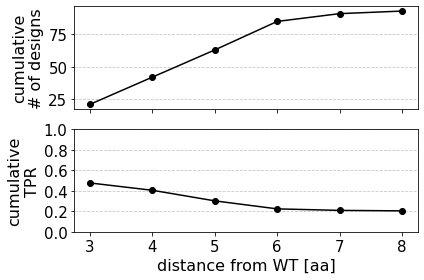

In [8]:
df_here = df.loc[df['tcrdock_pae'] < 5.5]

all_distances = sorted(np.unique(df_here['min_hamming_distance_from_struc'].values))


distances = df_here['min_hamming_distance_from_struc'].values
responses = df_here['resp_el4'].values

distance_to_resp = {}
for distance in np.unique(distances):
    dist_mask = distances == distance
    distance_to_resp[distance] = {True: np.sum(responses[dist_mask]), False: np.sum(~responses[dist_mask])}

cumulative_distance_to_resp = {}
for distance in all_distances:
    cumulative_distance_to_resp[distance] = {True: sum([distance_to_resp[dist][True] for dist in all_distances if dist <= distance]),
                                            False: sum([distance_to_resp[dist][False] for dist in all_distances if dist <= distance])}

# make plot of true positive rate below and including a certain distance threshold
# blow it, in a different subplot, make plot of total number of peptides
fontsize = 16

colsize = 6
rowsize = 2
ncols = 1
nrows = 2
fig, axs = plt.subplots(figsize=(colsize*ncols, rowsize*nrows), ncols=ncols, nrows=nrows, sharex=True)

ax = axs[0]
ax.plot(all_distances, [cumulative_distance_to_resp[distance][True] + cumulative_distance_to_resp[distance][False] for distance in all_distances], color='black', marker='o')
ax.set_ylabel('cumulative\n# of designs', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize-1)
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax = axs[1]
ax.plot(all_distances, [cumulative_distance_to_resp[distance][True] / (cumulative_distance_to_resp[distance][True] + cumulative_distance_to_resp[distance][False]) for distance in all_distances], color='black', marker='o')
ax.set_xlabel('distance from WT [aa]', fontsize=fontsize)
ax.set_ylabel('cumulative\nTPR', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize-1)
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('__pretty_cumulative_tpr_and_num_designs_vs_hamming_distance_from_wt.png')
plt.savefig('__pretty_cumulative_tpr_and_num_designs_vs_hamming_distance_from_wt.pdf')
plt.show()

In [6]:
# # 4 logoplots: true and tcrdock pae below 5.5; false and tcrdock pae below 5.5; flase and tcrdock pae above 5.5; false and tcrdock pae above 5.5
# # write the number of sequences in each logoplot

# AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY')
# import logomaker

# for fixed_e1 in [True, False]:

#     # for sampling_method in ['fixed_structure', 'sim_anneal']:

#     if fixed_e1:
#         # fixed_E1 in model name
#         curr_df = df[df['model'].str.contains('fixed_E1')]
#     else:
#         # no fixed_E1 in model name
#         curr_df = df[~df['model'].str.contains('fixed_E1')]
    
#     # curr_df = curr_df[curr_df['sampling_method'] == sampling_method]

#     curr_df = curr_df[curr_df['wt_for_design'] == 'magea3']

#     # true and tcrdock pae below 5.5
#     df_true_below = curr_df[(curr_df['tcrdock_pae'] < 5.5) & (curr_df['resp'] == True)]
#     df_false_below = curr_df[(curr_df['tcrdock_pae'] < 5.5) & (curr_df['resp'] == False)]


#     for title, df_ in zip([f'fixed E1 = {fixed_e1}' + ' - True Positives', f'fixed E1 = {fixed_e1}' + ' - False Positives'],
#                         [df_true_below, df_false_below]):

#         plt.figure(figsize=(10, 3))

#         if len(df_) == 0:
#             continue

#         len_seq = len(df_['sequence'].values[0])

#         # get sequences, make pwm
#         seqs = df_['sequence']
#         pwm = np.zeros((len_seq, len(AMINO_ACIDS)))
#         for seq in seqs:
#             assert len(seq) == len_seq
#             for i, aa in enumerate(seq):
#                 pwm[i, AMINO_ACIDS.index(aa)] += 1
#         pwm = pwm / pwm.sum(axis=1)[:, None]
#         pwm[np.isnan(pwm)] = 0

#         # plot pwm as logoplot
#         df_pwm = pd.DataFrame(pwm, columns=AMINO_ACIDS)
#         logomaker.Logo(df_pwm, ax=plt.gca())

#         plt.title(title + f'\n{len(seqs)} sequences', fontsize=14)

#         plt.xticks(np.arange(len_seq), np.arange(len_seq)+1)

#         # keep x axis labels, but nothing else pertaiing to the axis
        
#         # Hide the y-axis completely
#         plt.gca().get_yaxis().set_visible(False)

#         # Remove the x-axis horizontal line (spine)
#         plt.gca().spines['bottom'].set_visible(False)

#         # Remove all the spines
#         plt.gca().spines['top'].set_visible(False)
#         plt.gca().spines['right'].set_visible(False)
#         plt.gca().spines['left'].set_visible(False)
#         plt.gca().spines['right'].set_visible(False)

#         # Remove y-ticks
#         plt.gca().tick_params(axis='y', which='both', length=0)

#         # Remove x-tick marks but keep the labels
#         plt.gca().tick_params(axis='x', which='both', length=0)

#         plt.gca().tick_params(axis='x', labelsize=18)

#         plt.tight_layout()
#         # plt.savefig(f'__pretty_magea3_{title.replace(" ", "_").lower()}_logoplot.pdf')
#         # plt.savefig(f'__pretty_magea3_{title.replace(" ", "_").lower()}_logoplot.png')
#         plt.show()

In [7]:
# # 4 logoplots: true and tcrdock pae below 5.5; false and tcrdock pae below 5.5; flase and tcrdock pae above 5.5; false and tcrdock pae above 5.5
# # write the number of sequences in each logoplot

# AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY')
# import logomaker


# df_ = df[np.mean(df[['r1_el4', 'r2_el4', 'r3_el4']].values, axis=1) > np.max(cell_line_to_wt_scores['el4'])]

# print(df_)


# plt.figure(figsize=(10, 3))


# len_seq = len(df_['sequence'].values[0])

# # get sequences, make pwm
# seqs = df_['sequence']
# pwm = np.zeros((len_seq, len(AMINO_ACIDS)))
# for seq in seqs:
#     assert len(seq) == len_seq
#     for i, aa in enumerate(seq):
#         pwm[i, AMINO_ACIDS.index(aa)] += 1
# pwm = pwm / pwm.sum(axis=1)[:, None]
# pwm[np.isnan(pwm)] = 0

# # plot pwm as logoplot
# df_pwm = pd.DataFrame(pwm, columns=AMINO_ACIDS)
# logomaker.Logo(df_pwm, ax=plt.gca())

# plt.title('Designs better than wiltypes' + f'\n{len(seqs)} sequences', fontsize=14)

# plt.xticks(np.arange(len_seq), np.arange(len_seq)+1)

# # keep x axis labels, but nothing else pertaiing to the axis

# # Hide the y-axis completely
# plt.gca().get_yaxis().set_visible(False)

# # Remove the x-axis horizontal line (spine)
# plt.gca().spines['bottom'].set_visible(False)

# # Remove all the spines
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['left'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

# # Remove y-ticks
# plt.gca().tick_params(axis='y', which='both', length=0)

# # Remove x-tick marks but keep the labels
# plt.gca().tick_params(axis='x', which='both', length=0)

# plt.gca().tick_params(axis='x', labelsize=18)

# plt.tight_layout()
# # plt.savefig(f'__pretty_magea3_{title.replace(" ", "_").lower()}_logoplot.pdf')
# # plt.savefig(f'__pretty_magea3_{title.replace(" ", "_").lower()}_logoplot.png')
# plt.show()

In [8]:
# # for each sequence, plot the number of E-DPI---Y that are respected

# number_of_edpi_respected = []
# for i, row in df.iterrows():
    
#     seq = row['sequence']

#     edpi_respected = 0
#     if seq[0] == 'E':
#         edpi_respected += 1
#     if seq[2] == 'D':
#         edpi_respected += 1
#     if seq[3] == 'P':
#         edpi_respected += 1
#     if seq[4] == 'I':
#         edpi_respected += 1
#     if seq[-1] in {'Y'}:
#         edpi_respected += 1
    
#     number_of_edpi_respected.append(edpi_respected)

# df['number_of_edpi_respected'] = number_of_edpi_respected

# # number_of_edpi_respected == 3 and resp = true
# df_3 = df[(df['number_of_edpi_respected'] == 5) & (df['resp'] == False)]
# print(df_3['sequence'])


# ## barplot, color by Resp
# plt.figure(figsize=(10, 5))
# ax = plt.gca()

# for i, resp, color in zip([-1, 1], [True, False], ['darkorange', 'mediumaquamarine']):
#     df_here = df[df['resp'] == resp]
#     print(len(df_here))

#     # value counts
#     value_counts = df_here['number_of_edpi_respected'].value_counts().sort_index()
#     print(value_counts)

#     # barplot side by side
#     ax.bar(value_counts.index + i*0.2, value_counts.values, color=color, width=0.3, label=f'Resp = {resp}')


# ax.set_xticks(range(6))
# ax.set_xticklabels(range(6), fontsize=15)
# ax.set_yticklabels(map(int, ax.get_yticks()), fontsize=15)
# ax.set_xlabel('Number of E-DPI---Y respected', fontsize=18)
# ax.set_ylabel('Number of sequences', fontsize=18)
# ax.legend(fontsize=18, loc='upper left')
# plt.show()

In [9]:
# # 4 logoplots: true and tcrdock pae below 5.5; false and tcrdock pae below 5.5; flase and tcrdock pae above 5.5; false and tcrdock pae above 5.5
# # write the number of sequences in each logoplot

# AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY')
# import logomaker

# def get_pwm(df_):
#     seqs = df_['sequence']
#     pwm = np.zeros((len_seq, len(AMINO_ACIDS)))
#     for seq in seqs:
#         assert len(seq) == len_seq
#         for i, aa in enumerate(seq):
#             pwm[i, AMINO_ACIDS.index(aa)] += 1
#     pwm = pwm / pwm.sum(axis=1)[:, None]
#     pwm[np.isnan(pwm)] = 0
#     return pwm


# len_seq = len(df['sequence'].values[0])

# distances = sorted(np.unique(df['min_hamming_distance_from_struc'].values))

# nrows = 2
# ncols = len(distances)
# fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*2))

# for col, distance in enumerate(distances):

#     df_true_below = df[(df['tcrdock_pae'] < 5.5) & (df['resp'] == True) & (df['min_hamming_distance_from_struc'] == distance)]
#     df_false_below = df[(df['tcrdock_pae'] < 5.5) & (df['resp'] == False) & (df['min_hamming_distance_from_struc'] == distance)]

#     # get sequences, make pwm
#     pwm_true_below = get_pwm(df_true_below)
#     df_pwm_true_below = pd.DataFrame(pwm_true_below, columns=AMINO_ACIDS)
#     pwm_false_below = get_pwm(df_false_below)
#     df_pwm_false_below = pd.DataFrame(pwm_false_below, columns=AMINO_ACIDS)

#     for row, (title, df_, num_seqs) in enumerate(zip(['True Positives', 'False Positives'],
#                                                         [df_pwm_true_below, df_pwm_false_below],
#                                                         [len(df_true_below), len(df_false_below)])):

#         ax = axs[row, col]

#         logomaker.Logo(df_, ax=ax)

#         ax.set_title(title + f'\n{num_seqs} sequences', fontsize=14)

#         ax.set_xticks(np.arange(len_seq), np.arange(len_seq)+1)

#         # keep x axis labels, but nothing else pertaiing to the axis
        
#         # Hide the y-axis completely
#         ax.get_yaxis().set_visible(False)

#         # Remove the x-axis horizontal line (spine)
#         ax.spines['bottom'].set_visible(False)

#         # Remove all the spines
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         ax.spines['left'].set_visible(False)
#         ax.spines['right'].set_visible(False)

#         # Remove y-ticks
#         ax.tick_params(axis='y', which='both', length=0)

#         # Remove x-tick marks but keep the labels
#         ax.tick_params(axis='x', which='both', length=0)

#         ax.tick_params(axis='x', labelsize=18)

# plt.tight_layout()
# # plt.savefig(f'__pretty_magea3_{title.replace(" ", "_").lower()}_logoplot.pdf')
# # plt.savefig(f'__pretty_magea3_{title.replace(" ", "_").lower()}_logoplot.png')
# plt.show()

# '''
# Hard to really make sense of this to be honest. the E-DPI---Y motif seems to be pretty preserved, but not necessarily.
# Hard to know what's going on among the false positives.
# There seem to be epistatic interactions going on. That would have to explain the interactions I think.
# '''

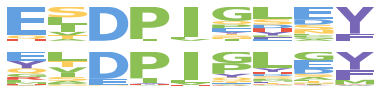

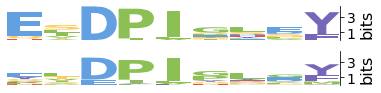

             sequence  r_el4_mean
Unnamed: 0                       
mage_p13    EVDPLGLEY   12.861457
mage_p31    ELDPIGLEY    6.772097
mage_p39    ETDPIGHEF    5.998380
mage_p43    ETDPIGFEF    7.652200
mage_p61    ESDPINESY   10.716776
mage_p76    EIDPIPLDY   12.044138
mage_p92    ESDPIEDEY    9.047026
mage_p95    QSDPIESEY    6.211165
EVDPLGLEY


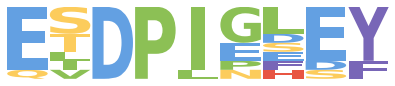

             sequence  r_el4_mean
Unnamed: 0                       
mage_p13    EVDPLGLEY   12.861457
mage_p31    ELDPIGLEY    6.772097
mage_p39    ETDPIGHEF    5.998380
mage_p43    ETDPIGFEF    7.652200
mage_p61    ESDPINESY   10.716776
mage_p76    EIDPIPLDY   12.044138
mage_p92    ESDPIEDEY    9.047026
mage_p95    QSDPIESEY    6.211165
EVDPLGLEY


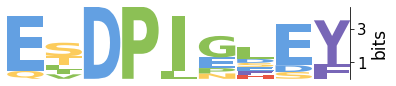

In [10]:
# 4 logoplots: true and tcrdock pae below 5.5; false and tcrdock pae below 5.5; flase and tcrdock pae above 5.5; false and tcrdock pae above 5.5
# write the number of sequences in each logoplot

AMINO_ACIDS = list('ACDEFGHIKLMNPQRSTVWY')
import logomaker

import sys
sys.path.append('../../../src/')
from global_constants import LOGOMAKER_COLORS

def entropy(p):
    return -np.nansum(p * np.log2(p + 1e-10))

def get_pwm(df_, use_entropy=False):
    seqs = df_['sequence']
    pwm = np.zeros((len_seq, len(AMINO_ACIDS)))
    for seq in seqs:
        assert len(seq) == len_seq
        for i, aa in enumerate(seq):
            pwm[i, AMINO_ACIDS.index(aa)] += 1
    pwm = pwm / pwm.sum(axis=1)[:, None]
    pwm[np.isnan(pwm)] = 0

    if use_entropy:
        ics = []
        for row in pwm:
            ics.append(np.log2(20) - entropy(row))
        ics = np.array(ics)
        pwm = pwm * ics[:, np.newaxis]

    return pwm

fontsize = 18

len_seq = len(df['sequence'].values[0])


def make_logoplot_tp_fp(use_entropy=False):

    nrows = 2
    ncols = 1
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5.4, nrows*0.7))

    df_true_below = df[(df['resp_el4'] == True)]
    df_false_below = df[(df['resp_el4'] == False)]

    # get sequences, make pwm
    pwm_true_below = get_pwm(df_true_below, use_entropy=use_entropy)
    df_pwm_true_below = pd.DataFrame(pwm_true_below, columns=AMINO_ACIDS)
    pwm_false_below = get_pwm(df_false_below, use_entropy=use_entropy)
    df_pwm_false_below = pd.DataFrame(pwm_false_below, columns=AMINO_ACIDS)

    for row, (title, df_, num_seqs) in enumerate(zip(['true positives', 'false positives'],
                                                        [df_pwm_true_below, df_pwm_false_below],
                                                        [len(df_true_below), len(df_false_below)])):

        ax = axs[row]

        logomaker.Logo(df_, ax=ax, color_scheme=LOGOMAKER_COLORS)

        # ax.set_title(title + f'\n{num_seqs} peptides', fontsize=fontsize)

        ax.set_xticks(np.arange(len_seq), np.arange(len_seq)+1)
        
        # # Hide the y-axis completely
        # ax.get_yaxis().set_visible(False)

        # # Remove y-ticks
        # ax.tick_params(axis='y', which='both', length=0)

        # # Remove x-tick marks but keep the labels
        # ax.tick_params(axis='x', which='both', length=0)

        # ax.tick_params(axis='x', labelsize=fontsize)

        ax.set_xticks([])

        # Remove all the spines
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        if not use_entropy:
            ax.spines['right'].set_visible(False)
            ax.set_yticks([])
        else:
            ax.yaxis.set_ticks_position('right')  # Set ticks on the right
            ax.yaxis.set_label_position('right')  # Set the label on the right
            ax.set_ylabel('bits', fontsize=fontsize-2)
            ax.set_yticks([1, 3])
            ax.tick_params(axis='y', labelsize=fontsize-4)

        if use_entropy:
            ax.set_ylim([0, np.log2(20)])
        else:
            ax.set_ylim([0, 1])
    
    if use_entropy:
        use_entropy_str = '_norm_entropy'
    else:
        use_entropy_str = ''

    plt.tight_layout()
    plt.savefig(f'__pretty_magea3_logoplot{use_entropy_str}.pdf')
    plt.savefig(f'__pretty_magea3_logoplot{use_entropy_str}.png')
    plt.show()


def make_logoplot_better_than_wt(use_entropy=False):

    df_better_than_wt = df[np.mean(df[['r1_el4', 'r2_el4', 'r3_el4']].values, axis=1) > np.max(cell_line_to_wt_scores['el4'])]

    print(df_better_than_wt[['sequence', 'r_el4_mean']])
    print(df_better_than_wt['sequence'].values[np.argmax(df_better_than_wt['r_el4_mean'].values)])

    num_seqs = len(df_better_than_wt)

    pwm_better_than_wt = get_pwm(df_better_than_wt, use_entropy=use_entropy)
    df_ = pd.DataFrame(pwm_better_than_wt, columns=AMINO_ACIDS)

    plt.figure(figsize=(5.6, 1.3))
    ax = plt.gca()

    logomaker.Logo(df_, ax=ax, color_scheme=LOGOMAKER_COLORS)

    # ax.set_title('designs better than mageaA3 and titin' + f'\n{num_seqs} peptides', fontsize=fontsize)

    ax.set_xticks(np.arange(len_seq), np.arange(len_seq)+1)

    if use_entropy:
        ax.set_ylim([0, np.log2(20)])
    else:
        ax.set_ylim([0, 1])

    # # Hide the y-axis completely
    # ax.get_yaxis().set_visible(False)

    # # Remove y-ticks
    # ax.tick_params(axis='y', which='both', length=0)

    # # Remove x-tick marks but keep the labels
    # ax.tick_params(axis='x', which='both', length=0)

    # ax.tick_params(axis='x', labelsize=fontsize)

    ax.set_xticks([])

    # Remove all the spines
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    if not use_entropy:
        ax.spines['right'].set_visible(False)
        ax.set_yticks([])
    else:
        ax.yaxis.set_ticks_position('right')  # Set ticks on the right
        ax.yaxis.set_label_position('right')  # Set the label on the right
        ax.set_ylabel('bits', fontsize=fontsize-1)
        ax.set_yticks([1, 3])
        ax.tick_params(axis='y', labelsize=fontsize-3)

    if use_entropy:
        use_entropy_str = '_norm_entropy'
    else:
        use_entropy_str = ''

    plt.tight_layout()
    plt.savefig(f'__pretty_magea3_better_than_wt_logoplot{use_entropy_str}.pdf')
    plt.savefig(f'__pretty_magea3_better_than_wt_logoplot{use_entropy_str}.png')
    plt.show()

make_logoplot_tp_fp(use_entropy=False)
make_logoplot_tp_fp(use_entropy=True)
make_logoplot_better_than_wt(use_entropy=False)
make_logoplot_better_than_wt(use_entropy=True)


Unnamed: 0
mage_p57    ECDPIGYEY
Name: sequence, dtype: object
Unnamed: 0
mage_p24    ESDPISSPY
mage_p31    ELDPIGLEY
mage_p56    EIDPIGYNY
mage_p61    ESDPINESY
mage_p66    ELDPIYLSY
mage_p69    ESDPITSAY
mage_p76    EIDPIPLDY
mage_p82    EIDPIQLDY
mage_p89    EADPIIDSY
mage_p92    ESDPIEDEY
Name: sequence, dtype: object
Unnamed: 0
mage_p3     EVDPVGLLF
mage_p13    EVDPLGLEY
mage_p39    ETDPIGHEF
mage_p40    QSDPIGHEY
mage_p43    ETDPIGFEF
mage_p44    HIDPIGYNY
mage_p87    ELDIIQPDY
mage_p91    ELDPIPLGF
mage_p95    QSDPIESEY
Name: sequence, dtype: object


/var/folders/hj/_3fznhqx3513kg4bkj6hjxw40000gn/T/ipykernel_15911/4246760589.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(map(int, ax.get_yticks()), fontsize=16)


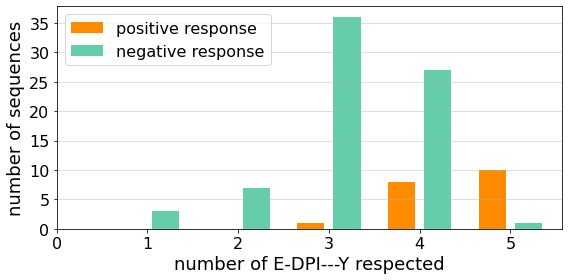

In [88]:
# for each sequence, plot the number of E-DPI---Y that are respected

number_of_edpi_respected = []
for i, row in df.iterrows():
    
    seq = row['sequence']

    edpi_respected = 0
    if seq[0] == 'E':
        edpi_respected += 1
    if seq[2] == 'D':
        edpi_respected += 1
    if seq[3] == 'P':
        edpi_respected += 1
    if seq[4] == 'I':
        edpi_respected += 1
    if seq[-1] in {'Y'}:
        edpi_respected += 1
    
    number_of_edpi_respected.append(edpi_respected)

df['number_of_edpi_respected'] = number_of_edpi_respected

# number_of_edpi_respected == 3 and resp = true
print(df[(df['number_of_edpi_respected'] == 5) & (df['resp_el4'] == False)]['sequence'])

print(df[(df['number_of_edpi_respected'] == 5) & (df['resp_el4'] == True)]['sequence'])

print(df[(df['number_of_edpi_respected'] < 5) & (df['resp_el4'] == True)]['sequence'])


## barplot, color by Resp
plt.figure(figsize=(8, 4))
ax = plt.gca()

for i, resp, color in zip([-1, 1], [True, False], ['darkorange', 'mediumaquamarine']):
    df_here = df[df['resp_el4'] == resp]

    # value counts
    value_counts = df_here['number_of_edpi_respected'].value_counts().sort_index()

    # barplot side by side
    ax.bar(value_counts.index + i*0.2, value_counts.values, color=color, width=0.3)

ax.grid(axis='y', alpha=0.5)

ax.set_xticks(range(6))
ax.set_xticklabels(range(6), fontsize=16)
ax.set_yticklabels(map(int, ax.get_yticks()), fontsize=16)
ax.set_xlabel('number of E-DPI---Y respected', fontsize=18)
ax.set_ylabel('number of sequences', fontsize=18)
ax.legend(['positive response', 'negative response'], fontsize=16, loc='upper left')

plt.tight_layout()
plt.savefig('__pretty_hits_vs_nnumber_of_edpiy_respected.pdf')
plt.savefig('__pretty_hits_vs_nnumber_of_edpiy_respected.png')
plt.show()

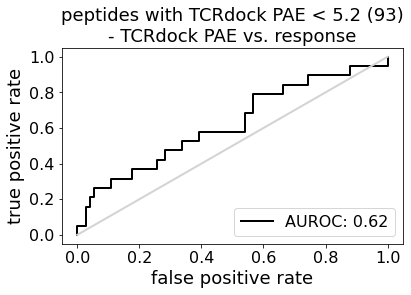

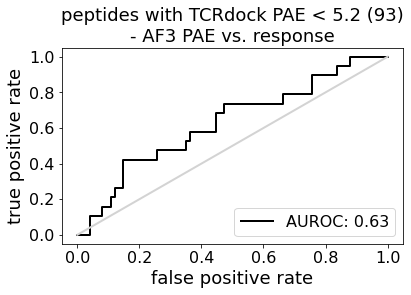

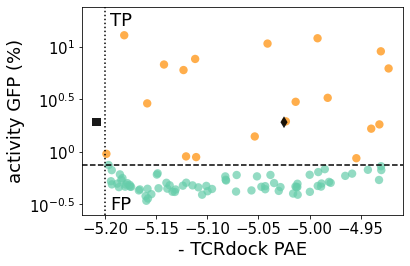

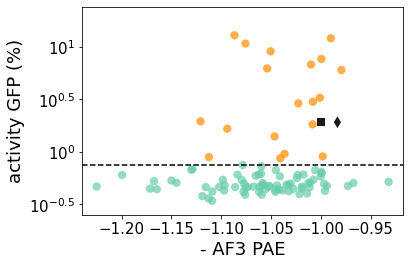

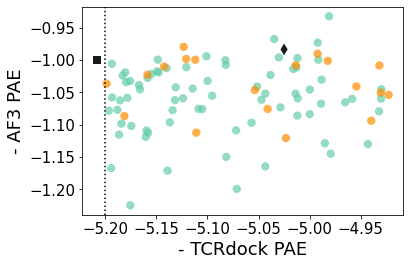

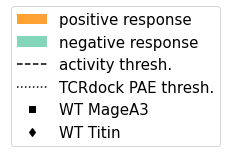

In [72]:

fontsize = 18

# roc curve plot and auroc for tcrdock_pae
fpr, tpr, _ = roc_curve(df['resp_el4'], -df['tcrdock_pae'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5.8, 4.2))
plt.title(f'peptides with TCRdock PAE < 5.2 ({len(df)})\n- TCRdock PAE vs. response', fontsize=fontsize)
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('false positive rate', fontsize=fontsize)
plt.ylabel('true positive rate', fontsize=fontsize)
plt.yticks(fontsize=fontsize-2)
plt.xticks(fontsize=fontsize-2)
plt.legend(loc='lower right', fontsize=fontsize-2)
plt.tight_layout()
plt.savefig(f'__pretty_magea3_roc_positive_peptides.png')
plt.savefig(f'__pretty_magea3_roc_positive_peptides.pdf')
plt.show()

fpr, tpr, _ = roc_curve(df['resp_el4'], -df['af3_ranking_scores'])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5.8, 4.2))
plt.title(f'peptides with TCRdock PAE < 5.2 ({len(df)})\n- AF3 PAE vs. response', fontsize=fontsize)
plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
plt.xlabel('false positive rate', fontsize=fontsize)
plt.ylabel('true positive rate', fontsize=fontsize)
plt.yticks(fontsize=fontsize-2)
plt.xticks(fontsize=fontsize-2)
plt.legend(loc='lower right', fontsize=fontsize-2)
plt.tight_layout()
plt.savefig(f'__pretty_magea3_roc_positive_peptides_af3.png')
plt.savefig(f'__pretty_magea3_roc_positive_peptides_af3.pdf')
plt.show()


colors = {True: 'darkorange', False: 'mediumaquamarine'}

predictor = 'tcrdock_pae'
measurement = 'r_el4_mean'

plt.figure(figsize=(5.8, 3.8))
for response in [False, True]:
    # remove boder color
    plt.scatter(-df[df['resp_el4'] == response][predictor], np.log10(df[df['resp_el4'] == response][measurement]), c=colors[response], edgecolors="none", alpha=0.7, s=70)

plt.scatter(-cell_line_to_pae_scores['el4'][0], np.log10(np.mean(cell_line_to_wt_scores['el4'][0])), marker='s', color='black', edgecolors="none", s=70, alpha=0.9)
plt.scatter(-cell_line_to_pae_scores['el4'][1], np.log10(np.mean(cell_line_to_wt_scores['el4'][0])), marker='d', color='black', edgecolors="none", s=70, alpha=0.9)

plt.axvline(-5.2, color='black', linestyle=':')
plt.axhline(np.log10(cell_line_to_cutoff['el4']), color='black', linestyle='--')

plt.xlabel('- TCRdock PAE', fontsize=fontsize)
plt.ylabel('activity GFP (%)', fontsize=fontsize)
yticks = [-0.5, 0, 0.5, 1]
plt.yticks(yticks, ['$10^{}$'.format('{' + str(y) + '}') for y in yticks], fontsize=fontsize-3)
plt.xticks(fontsize=fontsize-3)

plt.ylim([-0.6, np.log10(24)])

plt.text(-5.195, np.log10(16), 'TP', fontsize=fontsize)
plt.text(-5.195, -0.55, 'FP', fontsize=fontsize)
# plt.text(6.05, np.log10(35), 'FN', fontsize=fontsize)
# plt.text(6.05, np.log10(0.17), 'TN', fontsize=fontsize)

# plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f'__pretty_magea3_scatterplot.png')
plt.savefig(f'__pretty_magea3_scatterplot.pdf')
plt.show()


predictor = 'af3_ranking_scores'
measurement = 'r_el4_mean'

plt.figure(figsize=(5.8, 3.8))
for response in [False, True]:
    # remove boder color
    plt.scatter(-df[df['resp_el4'] == response][predictor], np.log10(df[df['resp_el4'] == response][measurement]), c=colors[response], edgecolors="none", alpha=0.7, s=70)

plt.scatter(-cell_line_to_af3_pae_scores['el4'][0], np.log10(np.mean(cell_line_to_wt_scores['el4'][0])), marker='s', color='black', edgecolors="none", s=70, alpha=0.9)
plt.scatter(-cell_line_to_af3_pae_scores['el4'][1], np.log10(np.mean(cell_line_to_wt_scores['el4'][0])), marker='d', color='black', edgecolors="none", s=70, alpha=0.9)

# plt.axvline(5.2, color='black', linestyle=':')
plt.axhline(np.log10(cell_line_to_cutoff['el4']), color='black', linestyle='--')

plt.xlabel('- AF3 PAE', fontsize=fontsize)
plt.ylabel('activity GFP (%)', fontsize=fontsize)
yticks = [-0.5, 0, 0.5, 1]
plt.yticks(yticks, ['$10^{}$'.format('{' + str(y) + '}') for y in yticks], fontsize=fontsize-3)
plt.xticks(fontsize=fontsize-3)

plt.ylim([-0.6, np.log10(24)])

# plt.text(5.17, np.log10(16), 'TP', fontsize=fontsize)
# plt.text(5.17, -0.55, 'FP', fontsize=fontsize)
# plt.text(6.05, np.log10(35), 'FN', fontsize=fontsize)
# plt.text(6.05, np.log10(0.17), 'TN', fontsize=fontsize)

# plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f'__pretty_magea3_scatterplot_AF3.png')
plt.savefig(f'__pretty_magea3_scatterplot_AF3.pdf')
plt.show()


predictor = 'tcrdock_pae'
measurement = 'af3_ranking_scores'

plt.figure(figsize=(5.8, 3.8))
for response in [False, True]:
    # remove boder color
    plt.scatter(-df[df['resp_el4'] == response][predictor], -df[df['resp_el4'] == response][measurement], c=colors[response], edgecolors="none", alpha=0.7, s=70)

plt.scatter(-cell_line_to_pae_scores['el4'][0], -cell_line_to_af3_pae_scores['el4'][0], marker='s', color='black', edgecolors="none", s=70, alpha=0.9)
plt.scatter(-cell_line_to_pae_scores['el4'][1], -cell_line_to_af3_pae_scores['el4'][1], marker='d', color='black', edgecolors="none", s=70, alpha=0.9)

plt.axvline(-5.2, color='black', linestyle=':')
# plt.axhline(np.log10(score_threshold), color='black', linestyle=':')

plt.ylabel('- AF3 PAE', fontsize=fontsize)
plt.xlabel('- TCRdock PAE', fontsize=fontsize)

# yticks = [-3, -2, -1, 0, 1, 2]
# plt.yticks(yticks, ['$10^{}$'.format('{' + str(int(y)) + '}') for y in yticks], fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-3)
plt.xticks(fontsize=fontsize-3)

# plt.text(5.4, np.log10(35), 'TP', fontsize=fontsize)
# plt.text(5.4, np.log10(0.17), 'FP', fontsize=fontsize)
# plt.text(6.05, np.log10(35), 'FN', fontsize=fontsize)
# plt.text(6.05, np.log10(0.17), 'TN', fontsize=fontsize)

# plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f'__pretty_magea3_scatterplot_tcrdock_vs_af3.png')
plt.savefig(f'__pretty_magea3_scatterplot_tcrdock_vs_af3.pdf')
plt.show()

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_handles = [Patch(facecolor=colors[True], alpha=0.8, label='positive response'),
                    Patch(facecolor=colors[False], alpha=0.8, label='negative response'),
                    Line2D([0], [0], color='black', linestyle='--', label='activity thresh.'),
                    Line2D([0], [0], color='black', linestyle=':', label='TCRdock PAE thresh.'),
                    Line2D([0], [0], color='black', marker='s', linestyle='None', label='WT MageA3'),
                    Line2D([0], [0], color='black', marker='d', linestyle='None', label='WT Titin')]


# put legends in separate figures
fig_leg_1 = plt.figure(figsize=(3.5, 2))
ax_leg_1 = fig_leg_1.add_subplot(111)
ax_leg_1.legend(handles=legend_handles, fontsize=fontsize-3, loc='center')
ax_leg_1.axis('off')
plt.tight_layout()
plt.savefig('__pretty_scatterplots_legend.png')
plt.savefig('__pretty_scatterplots_legend.pdf')
plt.show()

Fixed E1 - resp=False - E1?=False - 0.00
Fixed E1 - resp=False - E1?=True - 20.00
Fixed E1 - resp=True - E1?=False - 0.00
Fixed E1 - resp=True - E1?=True - 10.00
Not fixed E1 - resp=False - E1?=False - 54.00
Not fixed E1 - resp=False - E1?=True - 0.00
Not fixed E1 - resp=True - E1?=False - 3.00
Not fixed E1 - resp=True - E1?=True - 6.00
All - resp=False - E1?=False - 54.00
All - resp=False - E1?=True - 20.00
All - resp=True - E1?=False - 3.00
All - resp=True - E1?=True - 16.00


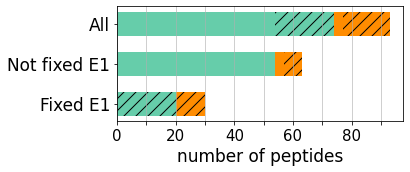

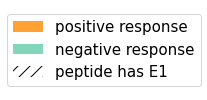

In [80]:
# some figure about fixing E1

colors = {True: 'darkorange', False: 'mediumaquamarine'}

hatches = {True: '//', False: ''}

df['is_E1_fixed'] = df['model'].str.contains('fixed_E1')
df['pep_starts_with_E'] = df['sequence'].apply(lambda x: x[0] == 'E')

df_e1 = df[df['is_E1_fixed']]
df_not_e1 = df[~df['is_E1_fixed']]

fontsize = 18

plt.figure(figsize=(5.8, 2.5))

for name, curr_df in zip(['Fixed E1', 'Not fixed E1', 'All'], [df_e1, df_not_e1, df]):

    num_peptides = len(curr_df)

    prev_num = 0.0
    for response in [False, True]:
        for pep_starts_with_E in [False, True]:
            num = len(curr_df[(curr_df['resp_el4'] == response) & (curr_df['pep_starts_with_E'] == pep_starts_with_E)]) # / num_peptides
            # plt.bar([name + f' ({num_peptides})'], [num/num_peptides], bottom=prev_num, color=colors[response], hatch=hatches[pep_starts_with_E], width=0.5)
            plt.barh([name], [num], left=prev_num, color=colors[response], hatch=hatches[pep_starts_with_E], height=0.6)
            prev_num += num

            print(f'{name} - resp={response} - E1?={pep_starts_with_E} - {num:.2f}')

plt.grid(axis='x', alpha=0.75)

# plt.xlim([0, 1])
plt.xlabel('number of peptides', fontsize=fontsize-1)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90], [0, '', 20, '', 40, '', 60, '', 80, ''], fontsize=fontsize-3)
# plt.xticks(fontsize=fontsize-3)
plt.yticks(fontsize=fontsize-1)

plt.tight_layout()
plt.savefig(f'__pretty_magea3_fixed_E1_barplot_horizontal.png')
plt.savefig(f'__pretty_magea3_fixed_E1_barplot_horizontal.pdf')
plt.show()

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_handles = [Patch(facecolor=colors[True], alpha=0.8, label='positive response'),
                    Patch(facecolor=colors[False], alpha=0.8, label='negative response'),
                    Patch(facecolor='none', hatch=hatches[True], label='peptide has E1')]


# put legends in separate figures
fig_leg_1 = plt.figure(figsize=(3, 1.5))
ax_leg_1 = fig_leg_1.add_subplot(111)
ax_leg_1.legend(handles=legend_handles, fontsize=fontsize-3, loc='center')
ax_leg_1.axis('off')
plt.tight_layout()
plt.savefig('__pretty_magea3_fixed_E1_barplot_legend.png')
plt.savefig('__pretty_magea3_fixed_E1_barplot_legend.pdf')
plt.show()


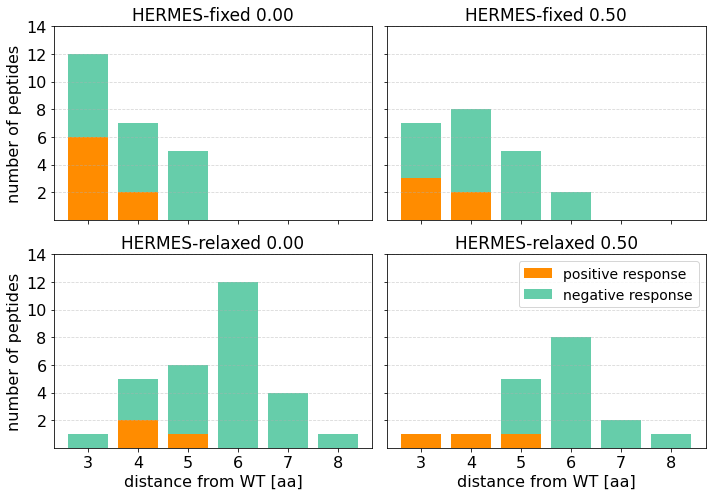

In [13]:
# make a barplot of success over distance from wildtype for the 4 model classes
models_of_interest = ['so3_convnet_base_ensemble__fixed_structure', 'so3_convnet_noise=0p5__fixed_structure', 'so3_convnet_base_ensemble__sim_anneal', 'so3_convnet_noise=0p5__sim_anneal']

model_name_to_pretty_name = {
    'so3_convnet_base_ensemble__fixed_structure': 'HERMES-fixed 0.00',
    'so3_convnet_noise=0p5__fixed_structure': 'HERMES-fixed 0.50',
    'so3_convnet_base_ensemble__sim_anneal': 'HERMES-relaxed 0.00',
    'so3_convnet_noise=0p5__sim_anneal': 'HERMES-relaxed 0.50'
}

model_plus_method = []
for i, row in df.iterrows():
    if 'base_ensemble' in row['model'] and row['sampling_method'] == 'fixed_structure':
        model_plus_method.append('so3_convnet_base_ensemble__fixed_structure')
    elif 'base_ensemble' in row['model'] and row['sampling_method'] == 'sim_anneal':
        model_plus_method.append('so3_convnet_base_ensemble__sim_anneal')
    elif 'noise' in row['model'] and row['sampling_method'] == 'fixed_structure':
        model_plus_method.append('so3_convnet_noise=0p5__fixed_structure')
    elif 'noise' in row['model'] and row['sampling_method'] == 'sim_anneal':
        model_plus_method.append('so3_convnet_noise=0p5__sim_anneal')
df['model_plus_method'] = model_plus_method

resp_to_color = {True: 'darkorange', False: 'mediumaquamarine'}

fontsize = 16

ncols = 2
nrows = 2
colsize = 5
rowsize = 3.5
fig, axs = plt.subplots(figsize=(ncols*colsize, nrows*rowsize), ncols=ncols, nrows=nrows, sharex=True, sharey=True)

for i, (ax, model) in enumerate(zip(axs.flatten(), models_of_interest)):
    mask = df['model_plus_method'] == model
    curr_df = df[mask]
    distances = curr_df['min_hamming_distance_from_struc'].values
    responses = curr_df['resp_el4'].values

    # barplot with distance on x axis, and on y axis positive resp in one color, negative resp in another color
    distance_to_resp = {}
    for distance in np.unique(distances):
        dist_mask = distances == distance
        distance_to_resp[distance] = {True: np.sum(responses[dist_mask]), False: np.sum(~responses[dist_mask])}
    
    distances = list(distance_to_resp.keys())
    pos_responses = [distance_to_resp[distance][True] for distance in distances]
    neg_responses = [distance_to_resp[distance][False] for distance in distances]

    row = i // ncols
    col = i % ncols

    ax.bar(distances, pos_responses, color=resp_to_color[True])
    ax.bar(distances, neg_responses, bottom=pos_responses, color=resp_to_color[False])
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    ax.set_title(model_name_to_pretty_name[model], fontsize=fontsize+1)
    ax.set_xticks([3, 4, 5, 6, 7, 8])
    ax.set_yticks([2, 4, 6, 8, 10, 12, 14])
    ax.tick_params(axis='both', labelsize=fontsize)
    if row == nrows-1: ax.set_xlabel('distance from WT [aa]', fontsize=fontsize)
    if col == 0: ax.set_ylabel('number of peptides', fontsize=fontsize)

    if row == nrows-1 and col == ncols-1:
        ax.legend(['positive response', 'negative response'], fontsize=fontsize-2)

plt.tight_layout()
plt.savefig('__pretty_hits_vs_hamming_distance_from_wt_split_by_model.png')
plt.savefig('__pretty_hits_vs_hamming_distance_from_wt_split_by_model.pdf')
plt.show()

In [14]:
# # boxplot with af3_ranking_scores on y axis, True or False on x axis based on Resp
# plt.figure(figsize=(6, 4))
# df.boxplot(column='af3_ranking_scores', by='resp', grid=False)
# plt.title('')
# plt.suptitle('')
# plt.xlabel('Response', fontsize=14)
# plt.ylabel('af3_tcr_pmhc_pae_score', fontsize=14)
# plt.show()

# # roc curve plot and auroc for tcrdock_pae
# mask = ~df['af3_ranking_scores'].isna()
# fpr, tpr, _ = roc_curve(df['resp'][mask], -df['af3_ranking_scores'][mask])
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(6, 4))
# plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
# plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('af3_ranking_scores', fontsize=14)
# plt.legend(loc='lower right', fontsize=12)
# plt.show()


# # boxplot with tcrdock_pae on y axis, True or False on x axis based on Resp
# plt.figure(figsize=(6, 4))
# df.boxplot(column='tcrdock_pae', by='resp', grid=False)
# plt.title('')
# plt.suptitle('')
# plt.xlabel('Response', fontsize=14)
# plt.ylabel('TCRdock PAE', fontsize=14)
# plt.show()

# # roc curve plot and auroc for tcrdock_pae
# fpr, tpr, _ = roc_curve(df['resp'], -df['tcrdock_pae'])
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(6, 4))
# plt.plot(fpr, tpr, color='black', lw=2, label='AUROC: %0.2f' % roc_auc)
# plt.plot([0, 1], [0, 1], color='lightgrey', lw=2)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('TCRdock PAE', fontsize=14)
# plt.legend(loc='lower right', fontsize=12)
# plt.show()


In [17]:
df.columns

Index(['sequence', 'model', 'sampling_method', 'wt_for_design', 'tcrdock_pae',
       'hamming_distances_from_magea3', 'hamming_distance_from_titin',
       'af3_ranking_scores', 'mw', 'weight', 'ul exact', 'c exact if 477',
       'r1_k562', 'r2_k562', 'r3_k562', 'r1_el4', 'r2_el4', 'r3_el4',
       'is_binder_by_netmhcpan', 'is_binder_by_netmhcpan__weak', 'resp_k562',
       'resp_el4', 'r_k562_mean', 'r_el4_mean',
       'min_hamming_distance_from_struc', 'hamming_distance_from_resp_struc',
       'number_of_edpi_respected', 'model_plus_method'],
      dtype='object')

In [19]:
top_peptides = df.loc[np.logical_and(df['min_hamming_distance_from_struc'] >= 4, df['resp_el4'] == True)]['sequence'].values

mhc = 'GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQKMEPRAPWIEQEGPEYWDQETRNMKAHSQTDRANLGTLRGYYNQSEDGSHTIQIMYGCDVGPDGRFLRGYRQDAYDGKDYIALNEDLRSWTAADMAAQITKRKWEAVHAAEQRRVYLEGRCVDGLRRYLENG'
tcra = 'KQEVTQIPAALSVPEGENLVLNCSFTDSAIYNLQWFRQDPGKGLTSLLLIQSSQREQTSGRLNASLDKSSGRSTLYIAASQPGDSATYLCAVRPGGAGPFFVVFGKGTKLSVIP'
tcrb = 'KAGVTQTPRYLIKTRGQQVTLSCSPISGHRSVSWYQQTPGQGLQFLFEYFSETQRNKGNFPGRFSGRQFSNSRSEMNVSTLELGDSALYLCASSFNMATGQYFGPGTRLTVT'


def make_json(mhc, tcra, tcrb, peptides, name=''):

    import json

    json_data = []
    for peptide in peptides:
        curr_json = {}
        curr_json['name'] = f'{name}_{peptide}'
        curr_json['modelSeeds'] = []
        curr_json['sequences'] = [
            {'proteinChain': {
                'sequence': mhc,
                'count': 1
            }},
            {'proteinChain': {
                'sequence': peptide,
                'count': 1
            }},
            {'proteinChain': {
                'sequence': tcra,
                'count': 1
            }},
            {'proteinChain': {
                'sequence': tcrb,
                'count': 1
            }},
        ]
        json_data.append(curr_json)
    
    with open(f'{name}.json', 'w') as f:
        json.dump(json_data, f, indent=4)

make_json(mhc, tcra, tcrb, top_peptides, name='magea3')